Loading data...
Original data shape: (15490, 20)
Added Season column
Found 729 outliers in Sales Excl across all branches
Data shape after removing outliers: (14761, 22)
Train data: (10196, 34) from 2023-01-01 00:00:00 to 2024-08-25 00:00:00
Validation data: (2289, 34) from 2024-08-26 00:00:00 to 2025-01-01 00:00:00
Test data: (2276, 34) from 2025-01-02 00:00:00 to 2025-05-11 00:00:00
Train split contains 18 unique branches
Validation split contains 18 unique branches
Test split contains 18 unique branches
Fitting preprocessor...
Starting feature selection with RFECV...
Selected 41 out of 42 features:
- DayOfWeek_0
- DayOfWeek_1
- DayOfWeek_2
- DayOfWeek_3
- DayOfWeek_4
- DayOfWeek_5
- DayOfWeek_6
- Season_autumn
- Season_spring
- Season_summer
- Season_winter
- Quarter_1
- Quarter_2
- Quarter_3
- Quarter_4
- Year
- Month
- Day
- WeekOfYear
- DaysSinceStart
- Temperature
- Precipitation
- Branch_mean_sales
- Branch_median_sales
- Branch_std_sales
- Branch_dow_avg_sales
- Branch_season_

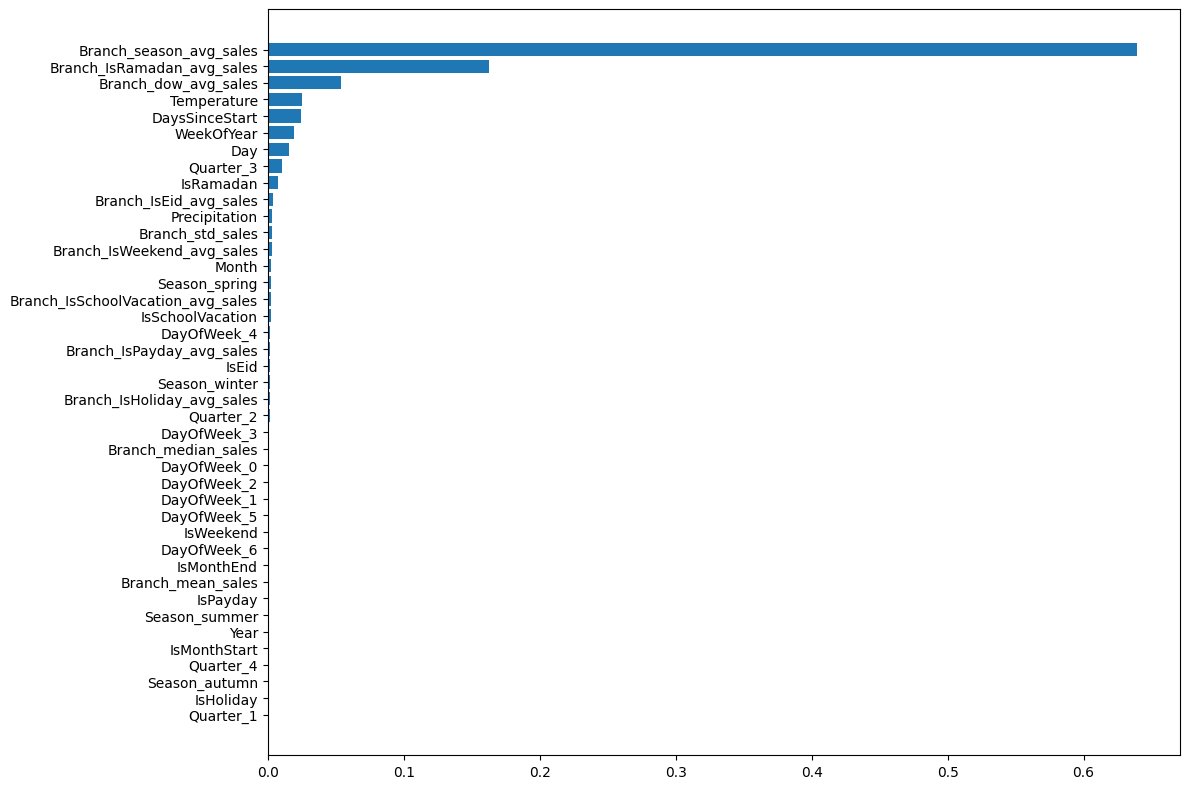

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 1. Load the data
print("Loading data...")
df = pd.read_csv("step8.csv", encoding="utf-8-sig")
print(f"Original data shape: {df.shape}")

# 2. Add season column based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'autumn'

df['Season'] = df['Month'].apply(get_season)
print("Added Season column")

# Create a date column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.sort_values('Date')

# 3. Handle outliers using IQR method - but do it PER BRANCH to account for different sales scales
def remove_outliers_by_group(df, column, group_column):
    outlier_indices = []
    
    for name, group in df.groupby(group_column):
        Q1 = group[column].quantile(0.25)
        Q3 = group[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get indices of rows with outliers
        outliers = group[(group[column] < lower_bound) | (group[column] > upper_bound)].index
        outlier_indices.extend(outliers)
    
    print(f"Found {len(outlier_indices)} outliers in {column} across all branches")
    
    # Return dataframe without outliers
    return df[~df.index.isin(outlier_indices)]

# Remove outliers by branch
df = remove_outliers_by_group(df, 'Sales Excl', 'Branch')
print(f"Data shape after removing outliers: {df.shape}")

# 4. DIFFERENT APPROACH: Make each branch's features separate from other branches
# Instead of treating branch as a categorical feature, we'll use a technique called "entity embedding"
# This is similar to how neural networks handle categorical variables with high cardinality

# Step 1: Calculate branch-specific statistics that will capture branch characteristics
branch_stats = df.groupby('Branch')['Sales Excl'].agg(['mean', 'median', 'std']).reset_index()
branch_stats.columns = ['Branch', 'Branch_mean_sales', 'Branch_median_sales', 'Branch_std_sales']

# Step 2: Also calculate branch-specific seasonal and day-of-week patterns
# This captures how each branch behaves differently on weekends, seasons, etc.
branch_dow_stats = df.groupby(['Branch', 'DayOfWeek'])['Sales Excl'].mean().reset_index()
branch_dow_stats.columns = ['Branch', 'DayOfWeek', 'Branch_dow_avg_sales']

branch_season_stats = df.groupby(['Branch', 'Season'])['Sales Excl'].mean().reset_index()
branch_season_stats.columns = ['Branch', 'Season', 'Branch_season_avg_sales']

# Merge these branch-specific characteristics back to the main dataframe
df = pd.merge(df, branch_stats, on='Branch', how='left')
df = pd.merge(df, branch_dow_stats, on=['Branch', 'DayOfWeek'], how='left')
df = pd.merge(df, branch_season_stats, on=['Branch', 'Season'], how='left')

# 5. Calculate relative sales (how much above/below average for this branch)
df['SalesRelativeToBranchAvg'] = df['Sales Excl'] / df['Branch_mean_sales']

# 6. Calculate branch-specific holiday effects
for holiday_col in ['IsWeekend', 'IsHoliday', 'IsRamadan', 'IsEid', 'IsSchoolVacation', 'IsPayday']:
    # Skip if all values are the same (e.g., if IsRamadan is always 0 in the dataset)
    if df[holiday_col].nunique() > 1:
        holiday_effect = df.groupby(['Branch', holiday_col])['Sales Excl'].mean().reset_index()
        holiday_effect.columns = ['Branch', holiday_col, f'Branch_{holiday_col}_avg_sales']
        df = pd.merge(df, holiday_effect, on=['Branch', holiday_col], how='left')

# 7. Split the data chronologically (not randomly)
# Determine train/validation/test split points (e.g., 70% train, 15% validation, 15% test)
# The key is making sure each branch has representation in all splits

# First, get unique dates
unique_dates = df['Date'].sort_values().unique()
train_end_idx = int(len(unique_dates) * 0.7)
val_end_idx = int(len(unique_dates) * 0.85)

train_dates = unique_dates[:train_end_idx]
val_dates = unique_dates[train_end_idx:val_end_idx]
test_dates = unique_dates[val_end_idx:]

# Now split the data based on these date ranges
train_df = df[df['Date'].isin(train_dates)]
val_df = df[df['Date'].isin(val_dates)]
test_df = df[df['Date'].isin(test_dates)]

print(f"Train data: {train_df.shape} from {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f"Validation data: {val_df.shape} from {val_df['Date'].min()} to {val_df['Date'].max()}")
print(f"Test data: {test_df.shape} from {test_df['Date'].min()} to {test_df['Date'].max()}")

# Check if each branch appears in each split
for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    branches_in_split = split_df['Branch'].unique()
    print(f"{split_name} split contains {len(branches_in_split)} unique branches")
    missing_branches = set(df['Branch'].unique()) - set(branches_in_split)
    if missing_branches:
        print(f"WARNING: {split_name} split is missing branches: {missing_branches}")

# 8. Define feature columns
# We'll include the branch-specific statistics we calculated earlier
# This allows the model to learn branch-specific patterns without directly predicting from branch name

# Categorical features to encode
categorical_features = ['DayOfWeek', 'Season', 'Quarter']  # Branch is now handled differently

# Boolean features (already 0/1)
boolean_features = ['IsWeekend', 'IsMonthStart', 'IsMonthEnd', 'IsHoliday', 
                   'IsRamadan', 'IsEid', 'IsSchoolVacation', 'IsPayday']

# Branch-specific features that capture unique branch characteristics
branch_features = ['Branch_mean_sales', 'Branch_median_sales', 'Branch_std_sales',
                  'Branch_dow_avg_sales', 'Branch_season_avg_sales']

# Add any branch-holiday interaction features we calculated
branch_holiday_features = [col for col in df.columns if col.startswith('Branch_Is') and col.endswith('_avg_sales')]
branch_features.extend(branch_holiday_features)

# Numerical features to scale
numerical_features = ['Year', 'Month', 'Day', 'WeekOfYear', 'DaysSinceStart', 
                     'Temperature', 'Precipitation', 'ExtremeWeather'] + branch_features

# Target variable
target = 'Sales Excl'

# 9. Create preprocessing pipeline
# For categorical features - use OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# For numerical features - use StandardScaler
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),
        ('bool', 'passthrough', boolean_features)
    ])

# 10. Feature selection using RFECV (Recursive Feature Elimination with Cross-Validation)
# Create a pipeline with preprocessing and model
model = RandomForestRegressor(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Prepare data for pipeline
X_train = train_df.drop([target, 'Date', 'Branch', 'SalesRelativeToBranchAvg'], axis=1)
y_train = train_df[target]

# Fit the pipeline to get feature names after preprocessing
print("Fitting preprocessor...")
preprocessor.fit(X_train)

# Get feature names after preprocessing
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
num_feature_names = numerical_features
bool_feature_names = boolean_features
all_feature_names = np.concatenate([cat_feature_names, num_feature_names, bool_feature_names])

# Now set up RFECV for feature selection
print("Starting feature selection with RFECV...")
rfecv = RFECV(
    estimator=model, 
    step=1,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    min_features_to_select=5,
    n_jobs=-1
)

# Apply preprocessing manually and then RFECV
X_train_preprocessed = preprocessor.transform(X_train)
rfecv.fit(X_train_preprocessed, y_train)

# Get selected features
selected_features_mask = rfecv.support_
selected_features = all_feature_names[selected_features_mask]

print(f"Selected {len(selected_features)} out of {len(all_feature_names)} features:")
for feature in selected_features:
    print(f"- {feature}")

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = rfecv.estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), all_feature_names[selected_features_mask][sorted_idx])
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature importance plot saved as 'feature_importance.png'")

# 11. Create a simpler approach to feature selection
# Since we've already preprocessed the data and found the important features,
# let's simplify by using the preprocessed data directly

# Instead of creating a complex pipeline with a function transformer,
# we'll create a column selector to use after preprocessing
class ColumnSelector:
    def __init__(self, selected_indices):
        self.selected_indices = selected_indices
    
    def transform(self, X):
        return X[:, self.selected_indices]
    
    def fit(self, X, y=None):
        return self

# Get indices of selected features
selected_indices = np.where(rfecv.support_)[0]

# Create the model that will use selected features
final_model = RandomForestRegressor(random_state=42)

# 12. Train the final model on selected features
print("Training final model...")
# Apply the column selection to preprocessed training data
X_train_selected = X_train_preprocessed[:, selected_indices]
final_model.fit(X_train_selected, y_train)

# Prepare validation data
X_val = val_df.drop([target, 'Date', 'Branch', 'SalesRelativeToBranchAvg'], axis=1)
X_val_preprocessed = preprocessor.transform(X_val)
X_val_selected = X_val_preprocessed[:, selected_indices]
y_val = val_df[target]

# Evaluate on validation set
val_pred = final_model.predict(X_val_selected)
val_mse = mean_squared_error(y_val, val_pred)
val_r2 = r2_score(y_val, val_pred)
print(f"Validation MSE: {val_mse:.2f}")
print(f"Validation R²: {val_r2:.4f}")

# 13. Analyze performance by branch
# Let's see how well the model works for each branch
branch_performance = {}
for branch in val_df['Branch'].unique():
    branch_mask = val_df['Branch'] == branch
    branch_X = X_val_preprocessed[branch_mask]
    branch_X_selected = branch_X[:, selected_indices]
    branch_y = y_val[branch_mask]
    branch_pred = final_model.predict(branch_X_selected)
    branch_mse = mean_squared_error(branch_y, branch_pred)
    branch_r2 = r2_score(branch_y, branch_pred)
    branch_performance[branch] = {'MSE': branch_mse, 'R2': branch_r2}

# Sort branches by R2 score
sorted_branches = sorted(branch_performance.items(), key=lambda x: x[1]['R2'], reverse=True)
print("\nValidation performance by branch:")
for branch, metrics in sorted_branches:
    print(f"{branch}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R2']:.4f}")

# 14. Hyperparameter tuning for the final model
print("\nStarting hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train_selected, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best validation score: {-grid_search.best_score_:.4f} MSE")

# 15. Evaluate the best model on test set
best_model = grid_search.best_estimator_
X_test = test_df.drop([target, 'Date', 'Branch', 'SalesRelativeToBranchAvg'], axis=1)
X_test_preprocessed = preprocessor.transform(X_test)
X_test_selected = X_test_preprocessed[:, selected_indices]
y_test = test_df[target]

test_pred = best_model.predict(X_test_selected)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"\nTest MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.4f}")

# Let's also check test performance by branch
branch_test_performance = {}
for branch in test_df['Branch'].unique():
    branch_mask = test_df['Branch'] == branch
    branch_X = X_test_preprocessed[branch_mask]
    branch_X_selected = branch_X[:, selected_indices]
    branch_y = y_test[branch_mask]
    branch_pred = best_model.predict(branch_X_selected)
    branch_mse = mean_squared_error(branch_y, branch_pred)
    branch_r2 = r2_score(branch_y, branch_pred)
    branch_test_performance[branch] = {'MSE': branch_mse, 'R2': branch_r2}

# Sort branches by R2 score
sorted_test_branches = sorted(branch_test_performance.items(), key=lambda x: x[1]['R2'], reverse=True)
print("\nTest performance by branch:")
for branch, metrics in sorted_test_branches:
    print(f"{branch}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R2']:.4f}")

# 16. Save the final model and preprocessor
import joblib
joblib.dump(preprocessor, 'sales_prediction_preprocessor.pkl')
joblib.dump(best_model, 'sales_prediction_model.pkl')
print("\nPreprocessor and model saved as 'sales_prediction_preprocessor.pkl' and 'sales_prediction_model.pkl'")

# 17. Example of how to use the model for predictions
print("\nExample of how to make predictions with the saved model:")
print("```python")
print("import joblib")
print("import pandas as pd")
print("")
print("# Load the preprocessor and model")
print("preprocessor = joblib.load('sales_prediction_preprocessor.pkl')")
print("model = joblib.load('sales_prediction_model.pkl')")
print("")
print("# Load new data (must have the same columns as the training data)")
print("new_data = pd.read_csv('new_data.csv')")
print("")
print("# Preprocess the new data")
print("X_new = new_data.drop(['Sales Excl', 'Date', 'Branch', 'SalesRelativeToBranchAvg'], axis=1)")
print("X_new_preprocessed = preprocessor.transform(X_new)")
print("")
print("# Make predictions")
print("predictions = model.predict(X_new_preprocessed)")
print("```")

print("\nData preprocessing and model training completed successfully!")